In [1]:
from models.softsplat import softsplat
import torch
import cv2
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from utils.flow_utils import *
from pytorch_msssim import ms_ssim
from PIL import Image
import math
from test_utils import *

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/data/maryam.sana/anaconda3/envs/mofa/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/maryam.sana/anaconda3/envs/mofa/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /data/maryam.sana/anaconda3/envs/mofa/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
def upsample_flow(flow_small, original_shape):
    flow_up = cv2.resize(flow_small, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR)
    scale_x = original_shape[1] / flow_small.shape[1]
    scale_y = original_shape[0] / flow_small.shape[0]
    flow_up[:, :, 0] *= scale_x
    flow_up[:, :, 1] *= scale_y
    return flow_up

def crop_bottom_slice(img_tensor):
    img = tensor_to_img(img_tensor)
    h = img.shape[0]
    start_row = int(h * (1 - slice_ratio))
    return img[start_row:]

def crop_bottom_slice_tensor(img_tensor):
    h = img_tensor.shape[2]
    start_row = int(h * (1 - slice_ratio))
    return img_tensor[:, :, start_row:]

def warp_with_flow(r1, flow_np):
    flow_tensor = torch.from_numpy(flow_np).permute(2, 0, 1).unsqueeze(0).float().cuda()
    metric = torch.ones_like(flow_tensor[:, :1])
    warped = softsplat(tenIn=r1, tenFlow=flow_tensor, tenMetric=metric, strMode='soft')
    return warped

def load_image_tensor(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # [1, C, H, W]
    return img.cuda()

def load_flow_tensor(path):
    # Assuming .flo file format — replace this if it's .png or .npy
    with open(path, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if magic != 202021.25:
            raise ValueError("Invalid .flo file")
        w = np.fromfile(f, np.int32, count=1)[0]
        h = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=2*w*h)
        flow = np.reshape(data, (h, w, 2))
    flow = torch.from_numpy(flow).permute(2, 0, 1).unsqueeze(0)  # [1, 2, H, W]
    return flow.cuda()

def tensor_to_img(t):
    t = t.detach().cpu().squeeze().permute(1, 2, 0).clamp(0, 1).numpy()
    return (t * 255).astype(np.uint8)

In [3]:
# Load data for vimeo
r1 = load_image_tensor('data/sequences/00009/0232/r1.png')
r2 = load_image_tensor('data/sequences/00009/0232/r2.png')
flow_fw = load_flow_tensor('data/sequences/00009/0232/Flow/im2.flo')  # r1 → target
flow_bw = load_flow_tensor('data/sequences/00009/0232/Flow/im2_backwards.flo') # r2 → target
target = load_image_tensor('data/sequences/00009/0232/im2.png')

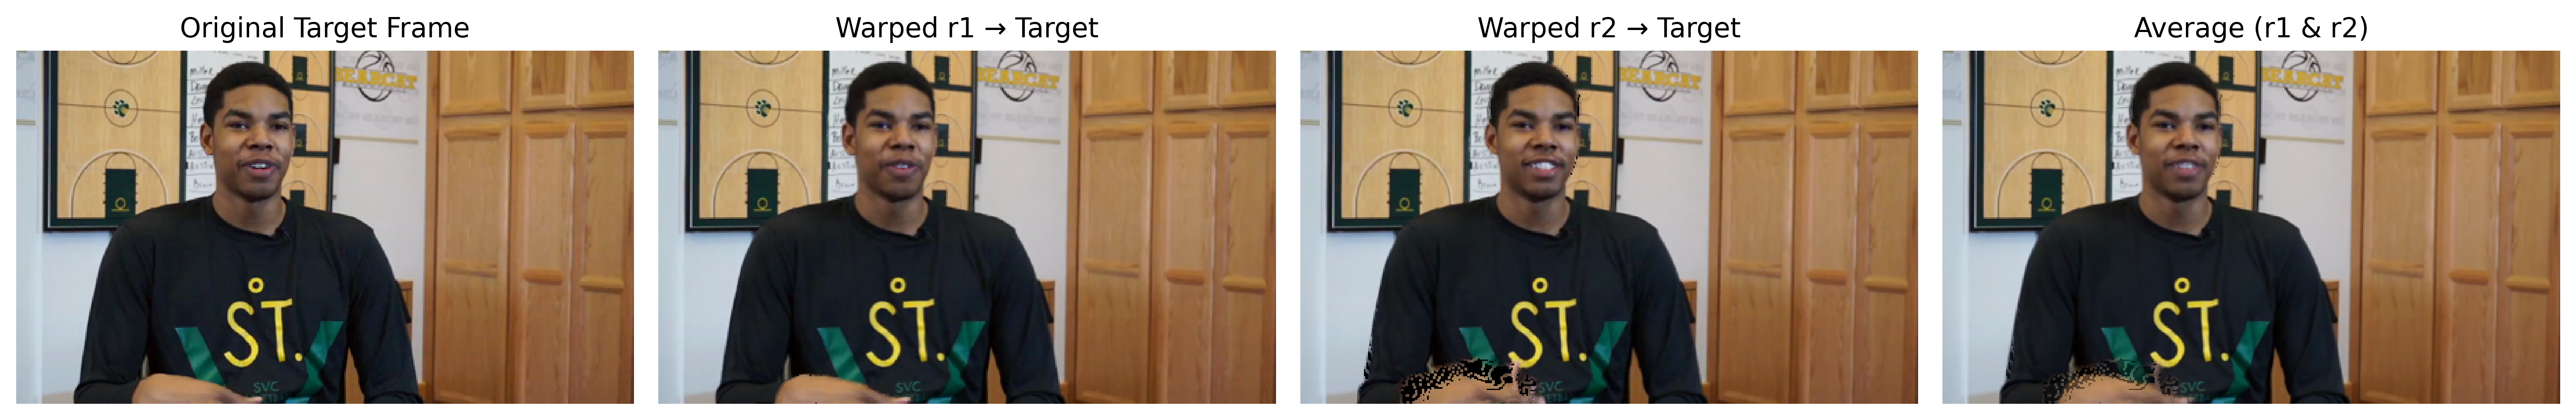

In [4]:
metric_fw = torch.ones_like(flow_fw[:, :1])  # shape: [1, 1, H, W]
metric_bw = torch.ones_like(flow_bw[:, :1])

# Warp using softsplat
warp_r1 = softsplat(tenIn=r1, tenFlow=flow_fw, tenMetric=metric_fw, strMode='soft')
warp_r2 = softsplat(tenIn=r2, tenFlow=flow_bw, tenMetric=metric_bw, strMode='soft')

# Naive average
warp_avg = (warp_r1 + warp_r2) / 2.0

plt.figure(figsize=(16, 7),dpi=400)

plt.subplot(1, 4, 1)
plt.imshow(tensor_to_img(target))
plt.title("Original Target Frame")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(tensor_to_img(warp_r1))
plt.title("Warped r1 → Target")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(tensor_to_img(warp_r2))
plt.title("Warped r2 → Target")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(tensor_to_img(warp_avg))
plt.title("Average (r1 & r2)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Warping Experiment

In [3]:
# ==== File Paths ====
r1_path = 'data/UVG/Beauty/intra_frames/decoded_q4/decoded_frame_0000.png'
flow_fw_path = 'data/UVG/Beauty/optical_flow/optical_flow_gop_8/flow_0000_0003.flo'
target_path = 'data/UVG/Beauty/images/frame_0003.png'

# ==== Load Data ====
r1 = load_image_tensor(r1_path)
flow_fw = load_flow_tensor(flow_fw_path)
target = load_image_tensor(target_path)

# # ==== Generate Constant Metric ====
# metric_fw = torch.ones_like(flow_fw[:, :1])  # Confidence map

# # ==== Warp r1 toward target ====
# warp_r1 = softsplat(
#     tenIn=r1,
#     tenFlow=flow_fw,
#     tenMetric=metric_fw,
#     strMode='soft'
# )

# # ==== Visualization ====
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# plt.imshow(tensor_to_img(target))
# plt.title("Target Frame (0001)")
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.imshow(tensor_to_img(r1))
# plt.title("Reference r1 (0000)")
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.imshow(tensor_to_img(warp_r1))
# plt.title("Warped r1 → 0003")
# plt.axis("off")

# plt.tight_layout()
# plt.show()

## Downsampled Warping

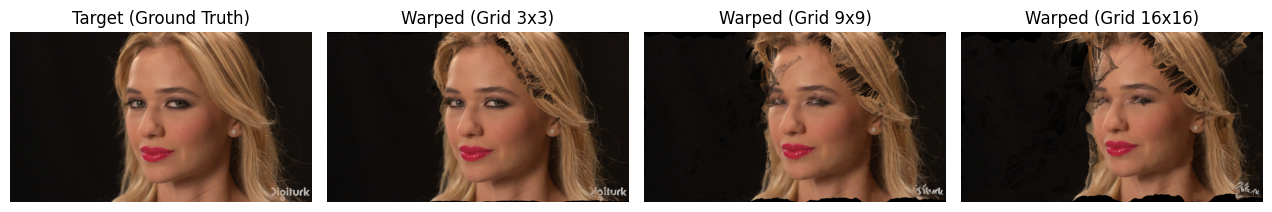

In [19]:
flow_orig = load_flo_file(flow_fw_path)  # H x W x 2

# === Grid Sizes to Try ===
grid_sizes = [3, 9, 16]
warp_results = []

for grid in grid_sizes:
    flow_down = reconstruct_flow(flow_orig, grid, method='weighted')
    flow_up = upsample_flow(flow_down, original_shape=flow_orig.shape[:2])
    warp = warp_with_flow(r1, flow_up)
    warp_results.append((grid, warp))

# === Display ===
plt.figure(figsize=(16, 5))

plt.subplot(1, len(warp_results) + 2, 1)
plt.imshow(tensor_to_img(target))
plt.title("Target (Ground Truth)")
plt.axis("off")

for idx, (grid, warped) in enumerate(warp_results):
    plt.subplot(1, len(warp_results) + 2, idx + 2)
    plt.imshow(tensor_to_img(warped))
    plt.title(f"Warped (Grid {grid}x{grid})")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Compressed Flow Warping

In [7]:
# flow_rgb_loaded = cv2.imread("data/flow_grid9.png")
# flow_rgb_loaded = cv2.cvtColor(flow_rgb_loaded, cv2.COLOR_BGR2RGB)
# W, H = r1.shape[2], r1.shape[3] 
# # === Resize to match r1 shape ===
# target_height, target_width = W,H # r1 is [1, C, H, W]
# flow_rgb_loaded = cv2.resize(flow_rgb_loaded, (target_width, target_height), interpolation=cv2.INTER_LINEAR)

# # === Recover flow ===
# flow_recovered = color_to_flow(flow_rgb_loaded)

# # === Rescale vectors to image size ===
# h_ratio = target_height / flow_rgb_loaded.shape[0]
# w_ratio = target_width / flow_rgb_loaded.shape[1]
# flow_recovered[..., 0] *= w_ratio
# flow_recovered[..., 1] *= h_ratio

# # === Warping ===
# warp_orig = warp_with_flow(r1, flow_orig)
# warp_recon = warp_with_flow(r1, flow_recovered)

# # === Show Results ===
# plt.figure(figsize=(15, 5),dpi= 300)

# plt.subplot(1, 3, 1)
# plt.imshow(tensor_to_img(target))
# plt.title("Target (Ground Truth)")
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.imshow(tensor_to_img(warp_orig))
# plt.title("Warped with Original Flow")
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.imshow(tensor_to_img(warp_recon))
# plt.title("Warped with Reconstructed Flow")
# plt.axis("off")

# plt.tight_layout()
# plt.show()

## Downsample Compressed Flow Warping

In [4]:
# === Flows ===
flow_orig = load_flo_file(flow_fw_path)
flow_down = reconstruct_flow(flow_orig, 9, method='weighted')
flow_up = upsample_flow(flow_down, original_shape=flow_orig.shape[:2])

flow_decoded_rgb = cv2.imread('data/flow_grid9.png')
decoded_flow = color_to_flow(flow_decoded_rgb)
decoded_up = upsample_flow(decoded_flow, original_shape=flow_orig.shape[:2])

# === Flow Images (RGB) ===
orig_flow_img = flow_to_color(flow_orig)
down_flow_img = flow_to_color(flow_down)
flow_decoded_img = cv2.cvtColor(flow_decoded_rgb, cv2.COLOR_BGR2RGB)

# === Warped Images ===
warp_orig = warp_with_flow(r1, flow_orig)
warp_up = warp_with_flow(r1, flow_up)
warp_decoded = warp_with_flow(r1, decoded_up)

# === Plotting ===
plt.figure(figsize=(15, 8), dpi=300)

# Row 1: Flow visualizations
plt.subplot(2, 3, 1)
plt.imshow(orig_flow_img)
plt.title("Original Flow")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(down_flow_img)
plt.title("Downsampled Flow")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(flow_decoded_img)
plt.title("Decoded Flow (PNG)")
plt.axis("off")

# Row 2: Warped outputs
plt.subplot(2, 3, 4)
plt.imshow(tensor_to_img(warp_orig))
plt.title(f"Warped (Original)\n")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(tensor_to_img(warp_up))
plt.title(f"Warped (Upsampled)\n")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imsave('output/warp_decoded.png', tensor_to_img(warp_decoded))

plt.title(f"Warped (Decoded RGB)\n")
plt.axis("off")

plt.tight_layout()
plt.show()


[ WARN:0@4.439] global loadsave.cpp:268 findDecoder imread_('data/flow_grid9.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [7]:
plt.imsave('data/warping/warp_decoded.png', tensor_to_img(warp_decoded))
plt.imsave('data/warping/warp_downsample.png', tensor_to_img(warp_up))
plt.imsave('data/warping/warp_orig.png', tensor_to_img(warp_orig))

In [5]:
target = Image.open(target_path).convert("RGB")
decoded = Image.open('data/warping/warp_decoded.png').convert("RGB")
downsample = Image.open('data/warping/warp_downsample.png').convert("RGB")
orig = Image.open('data/warping/warp_orig.png').convert("RGB")
calculate_metrics_batch([target], [orig])


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/src/i3dpt_jit.py", line 62, in forward
    out13 = (self.mixed_5b).forward(out12, )
    out14 = (self.mixed_5c).forward(out13, )
    out15 = (self.avg_pool).forward(out14, )
             ~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    out16 = (self.dropout).forward(out15, )
    out17 = (self.conv3d_0c_1x1).forward(out16, )
  File "code/__torch__/torch/nn/modules/pooling.py", line 28, in forward
  def forward(self: __torch__.torch.nn.modules.pooling.AvgPool3d,
    input: Tensor) -> Tensor:
    _2 = torch.avg_pool3d(input, [2, 7, 7], [1, 1, 1], [0, 0, 0], False, True, None)
         ~~~~~~~~~~~~~~~~ <--- HERE
    return _2

Traceback of TorchScript, original code (most recent call last):
  File "/home/skoroki/video-sg/env/lib/python3.8/site-packages/torch/nn/modules/pooling.py", line 675, in forward
    def forward(self, input: Tensor) -> Tensor:
        return F.avg_pool3d(input, self.kernel_size, self.stride,
               ~~~~~~~~~~~~ <--- HERE
                            self.padding, self.ceil_mode, self.count_include_pad, self.divisor_override)
RuntimeError: input image (T: 1 H: 7 W: 7) smaller than kernel size (kT: 2 kH: 7 kW: 7)


In [29]:
def process_and_plot_warp_slice_with_metrics(r1_path, target_path, rgb_flows, save_path):
    # Load source and target frames
    r1 = load_image_tensor(r1_path)
    target = load_image_tensor(target_path)

    H, W = r1.shape[2], r1.shape[3]
    warped_results = []

    for label, rgb_flow_path in rgb_flows.items():
        flow_rgb = cv2.imread(rgb_flow_path)
        flow_rgb = cv2.cvtColor(flow_rgb, cv2.COLOR_BGR2RGB)

        flow = color_to_flow(flow_rgb)
        flow = cv2.resize(flow, (W, H), interpolation=cv2.INTER_LINEAR)

        scale_x = W / flow_rgb.shape[1]
        scale_y = H / flow_rgb.shape[0]
        flow[..., 0] *= scale_x
        flow[..., 1] *= scale_y

        warped = warp_with_flow(r1, flow)
        warped_results.append((label, warped))

    target_img = tensor_to_img(target)
    target_pil = Image.fromarray(target_img)
    target_tensor = transform(target_pil).unsqueeze(0)

    n_rows = len(warped_results) + 1
    plt.figure(figsize=(7, 1 * n_rows), dpi=400)

    # Target image
    plt.subplot(n_rows, 1, 1)
    plt.imshow(target_img)
    plt.title("Target Frame")
    plt.axis("off")

    for i, (label, warped_tensor) in enumerate(warped_results):
        warped_img = tensor_to_img(warped_tensor)
        warped_pil = Image.fromarray(warped_img)
        pred_tensor = transform(warped_pil).unsqueeze(0)
        
        # PSNR and MS-SSIM over full frame
        psnr_value = psnr(target_tensor, pred_tensor).item()
        msssim_score = ms_ssim(target_tensor, pred_tensor, data_range=255, size_average=True).item()

        title = f"{label}\nPSNR: {psnr_value:.2f} dB | MS-SSIM: {msssim_score:.4f}"
        plt.subplot(n_rows, 1, i + 2)
        plt.imshow(warped_img)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to: {save_path}")


In [30]:
r1_path = 'data/UVG/Jockey/intra_frames/decoded_q8/decoded_frame_0008.png'
target_path = 'data/UVG/Jockey/images/frame_0014.png'

rgb_flows = {
    "Original Flow": 'data/UVG/Jockey/optical_flow/optical_flow_gop_8/flow_0008_0014.png',
    "Downsample: Grid 3": 'data/UVG/Jockey/optical_flow/optical_flow_gop_8/grid_3/flow_0008_0014.decoded.png',
    "Downsample: Grid 9": 'data/UVG/Jockey/optical_flow/optical_flow_gop_8/grid_9/flow_0008_0014.decoded.png',
    "Downsample: Grid 15": 'data/UVG/Jockey/optical_flow/optical_flow_gop_8/grid_15/flow_0008_0014.decoded.png',
}

process_and_plot_warp_slice_with_metrics(r1_path, target_path, rgb_flows, save_path= 'data/warp_jockey.png')

Plot saved to: data/warp_jockey.png
